In [1]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

# For ODESolver
from scipy import integrate

# PyTorch for Dataloaders
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Optuna for hyperparameter searching
import optuna

# Path to import created files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

# Import created functions
from data import make_dataset as mkds
from visualization import visualize as vis
from models import train_model as tm

In [2]:
rng = random.PRNGKey(42)

x = mkds.rho(rng, 300)

x, train_samps = mkds.perturb(batchsize=10000,
                    rng = rng,
                    sigma = 0.01, 
                    tau = 0.03, 
                    M = 291,
                    restrict_M = True)

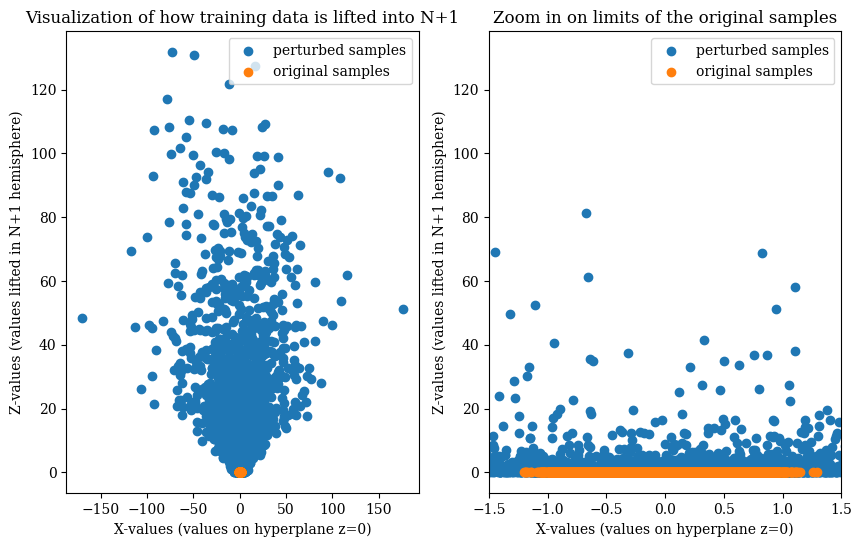

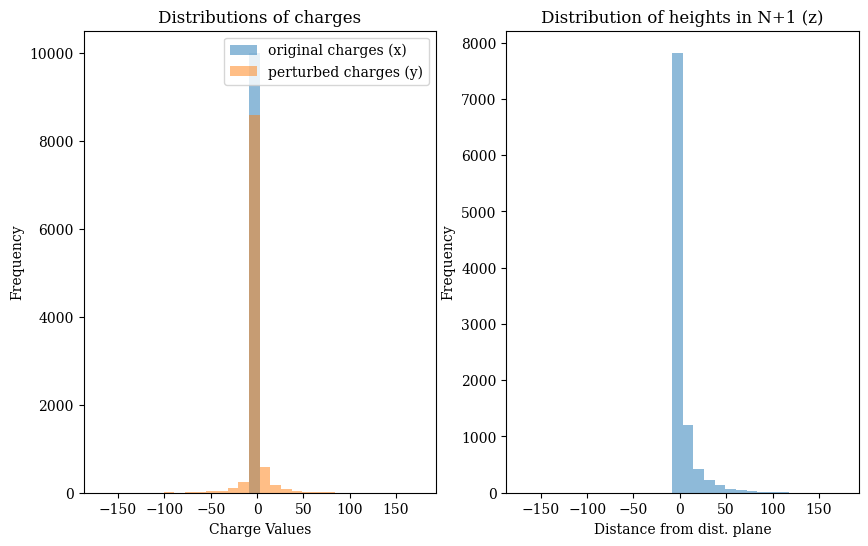

In [3]:
vis.perturb_vis(batchsize=10000, rng=rng)
vis.perturbed_dist_vis(batchsize=10000, rng=rng)

(1000, 2)
(1000, 2)


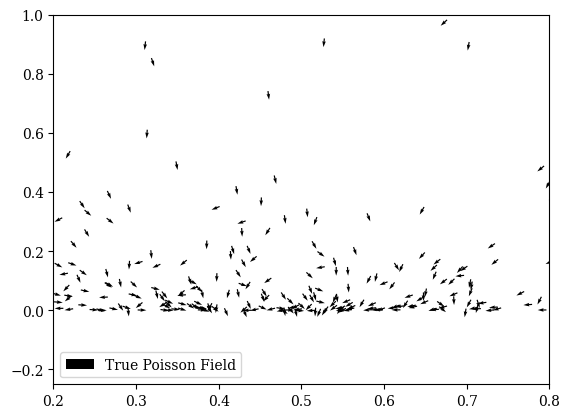

In [4]:
x, y = mkds.perturb(batchsize=1000,
                    rng = rng,
                    sigma = 0.01, 
                    tau = 0.03, 
                    M = 291,
                    restrict_M = True)
E = mkds.empirical_field(x, y)


limit = 1

print(y.shape)
print(E.shape)
plt.quiver(y[:,0], y[:,1], E[:,0], E[:,1], label='True Poisson Field');
plt.ylim(-0.25,limit)
plt.xlim(.2, .8)
plt.legend()
plt.show()

This commented code creates the datasets used in the NN

In [5]:
# # Create two instances of creating data due to running out of memory when go above
# # samplesize of 35,000
# train1_data = mkds.get_NN_data(rng, samplesize=35000, save=False, filename='')
# train2_data = mkds.get_NN_data(rng+1, samplesize=35000, save=False, filename='')
# # Collect the training data (y) & training labels (E)
# train_y = jnp.concatenate((train1_data[0], train2_data[0]), axis=0)
# train_E = jnp.concatenate((train1_data[1], train2_data[1]), axis=0)
# # Put them into the format that save_gen_data expects
# train_data = (train_y, train_E)
# # Save data
# mkds.save_gen_data(filename='train_data', data=train_data)
# mkds.get_NN_data(rng+2, samplesize=8750, save=True, filename='val_data')
# mkds.get_NN_data(rng+3, samplesize=8750, save=True, filename='test_data')


# # print('y =', train_data[0][:,0])
# # print('E =', train_data[0][:,1])
# # plt.scatter(train_data[0][:,0], train_data[0][:,1])

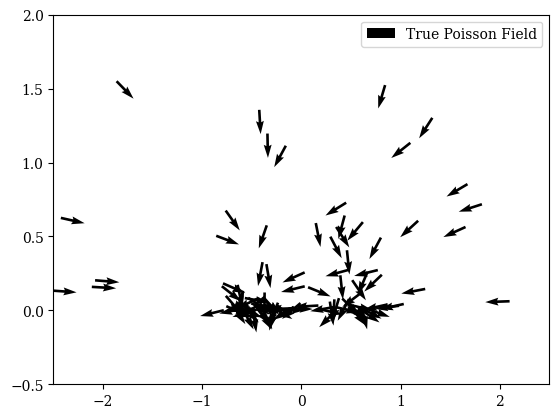

In [6]:
train_loader = mkds.get_dataloader(file_name='train_data',
                              batchsize=128,
                              shuffle=True)   
val_loader = mkds.get_dataloader(file_name='val_data',
                              batchsize=128,
                              shuffle=False)   
test_loader = mkds.get_dataloader(file_name='test_data',
                              batchsize=128,
                              shuffle=False)   

vis.quiver_plot(train_loader, xlim=(-2.5, 2.5), ylim=(-.5, 2))

**Training the model using Optuna**

In [7]:
CHECKPOINT_PATH = module_path + "/saved_models"
model_dir = CHECKPOINT_PATH + '/MLPRegressor/version_1'
file_path = model_dir + '/metrics' + '/best_eval.json'

In [8]:
# trainer = tm.MLPRegressTrainer(hidden_dims=[64, 128, 256, 512, 256, 128, 64],
#                             output_dim=2,
#                             optimizer_hparams={'lr': 4e-3,
#                                                'optimizer': 'adam'},
#                             logger_params={'base_log_dir': CHECKPOINT_PATH},
#                             exmp_input=next(iter(train_loader))[0:1],
#                             check_val_every_n_epoch=1)

# metrics = trainer.train_model(train_loader,
#                               val_loader,
#                               test_loader,
#                               num_epochs=25)

trainer_load = tm.MLPRegressTrainer.load_from_checkpoint(checkpoint=model_dir,
                                       exmp_input=next(iter(train_loader))[0:1])


                              MLPRegressor Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module       ┃ inputs          ┃ outputs         ┃ params          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         │ MLPRegressor │ -               │ float32[128,2]  │                 │
│         │              │ float32[128,2]  │                 │                 │
│         │              │ - train: True   │                 │                 │
├─────────┼──────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Dense_0 │ Dense        │ float32[128,2]  │ float32[128,64] │ bias:           │
│         │              │                 │                 │ float32[64]     │
│         │              │                 │                 │ kernel:         │
│         │              │                 │                 │ float32[2,64]   │
│         │              │ 

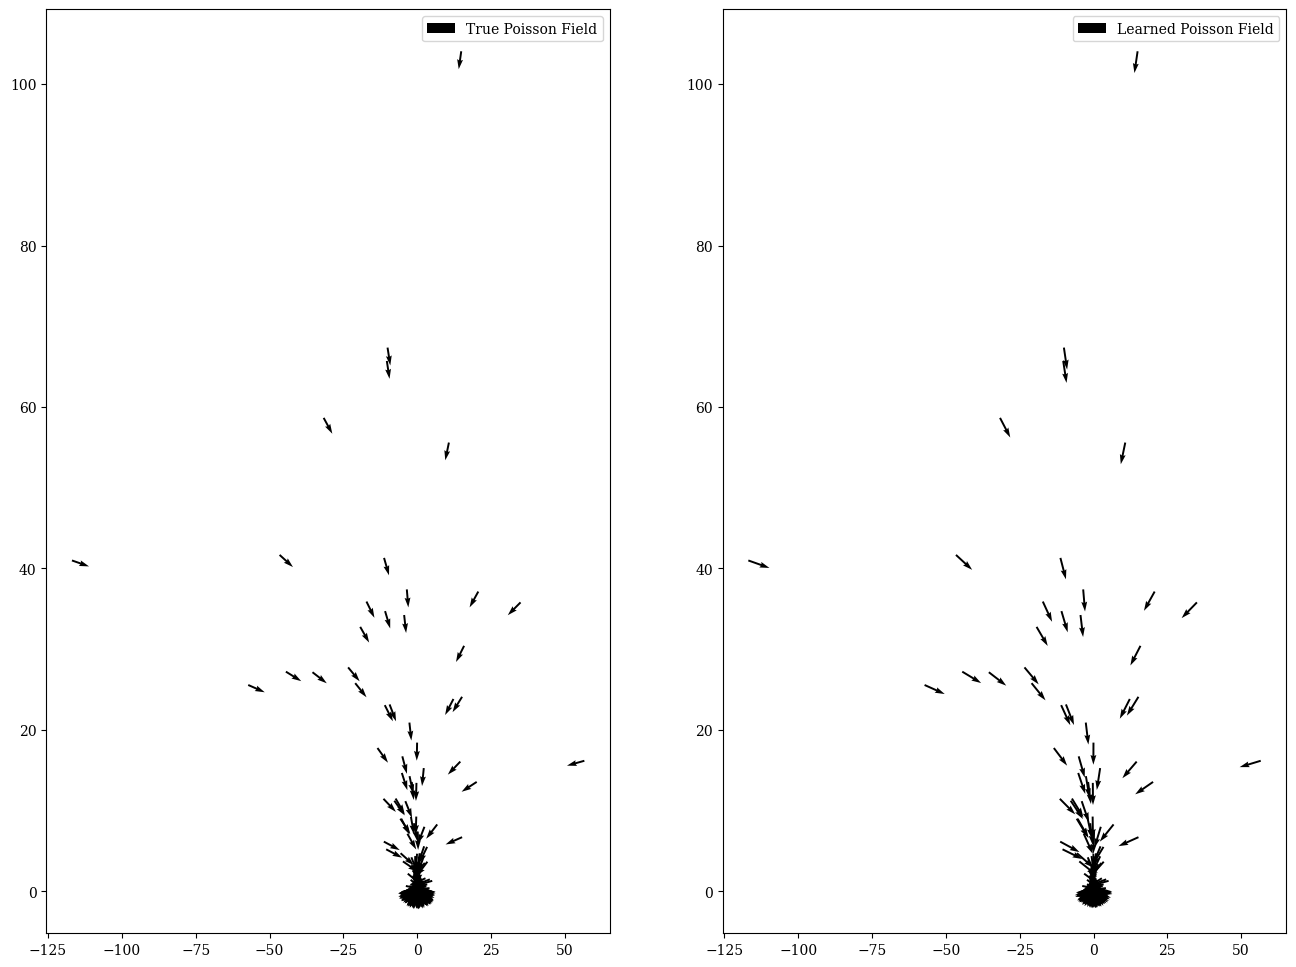

In [9]:
rng = jax.random.PRNGKey(43)
x = mkds.get_NN_data(rng, 300)
# Inference
model_bd = trainer_load.bind_model()
y_pred = model_bd(x[0])
fig, ax = plt.subplots(1,2, figsize=(16,12))

ax[0].quiver(x[0][:,0], x[0][:,1], x[1][:,0], x[1][:,1], cmap='viridis', label='True Poisson Field');
ax[0].legend();
ax[1].quiver(x[0][:,0], x[0][:,1], y_pred[:,0], y_pred[:,1], cmap='viridis', label='Learned Poisson Field');
ax[1].legend()
plt.show()

**Sampling from the distribution**

In [10]:
def prior_sampling(dshape, zmax=30):
    """
    Sampling initial data from p_prior on z=z_max hyperplane.
    See sect 3.3 in PFGM paper.
    Found in methods.py on Github.
    """
    rng = jax.random.PRNGKey(32)
    rng, subkey1, subkey2 = jax.random.split(key=rng, num=3)
    # Sample the radius from p_radius (details in Appendix A.4 in PFGM paper)
    max_z = zmax
    N = 2 # 1 dimensional data + 1 additional dimension (z)
    # Sampling from inverse-beta distribution
    samples_norm = random.beta(key=subkey1, a=N / 2. - 0.5, b=0.5, shape=(dshape[0], 1)) #R1 
    inverse_beta = samples_norm / (1 - samples_norm) # R2
    # Sampling from p_radius(R) by change-of-variable
    samples_norm = jnp.sqrt(max_z ** 2 * inverse_beta) # R3
    # clip the sample norm (radius)
    samples_norm = jnp.clip(samples_norm, 1, 3000) # 3000 in place of sampling.upper_norm

    # Uniformly sample the angle direction
    gaussian = random.normal(key=subkey2, shape=(dshape[0], 1))
    unit_gaussian = gaussian / jnp.linalg.norm(gaussian, axis=1, keepdims=True)

    # Radius times the angle direction
    init_samples = unit_gaussian * samples_norm
    zmax_coord = jnp.ones((len(init_samples), 1)) * max_z
    init_samples = jnp.concatenate((init_samples, zmax_coord), axis=1)

    return init_samples


def ode_sampler(shape, zmax=30, eps=1e-3, verbose=False, method='RK45'):

    samples = prior_sampling((shape,))
    samples = samples.ravel()
    
    def ode_func(t, x):
        # Convert the flattened array into the shape the NN expects
        x = x.reshape(((-1, 2)))
        # Change-of-variable z=exp(t) for faster sampling
        z = np.exp(t)
        # Update the z-dimension before passing to NN
        if type(x) == np.ndarray:
            x[:, 1] = z
            input_vec = x
        else:
            input_vec = x.at[:, 1].set(z)
        # Get trained model
        model_bd = trainer_load.bind_model()
        # Predicted normalized Poisson field
        v = model_bd(input_vec)
        # Get dx/dz as shown in Sect. 3.3
        dt_dz = 1 / (v[:, -1] + 1e-5)
        dx_dt = v[:, 0]     
        dx_dz = dx_dt * dt_dz
        driftx = v.at[:, 0].set(dx_dz * z)
        drift = driftx.at[:, 1].set(z)
        del v
        del driftx
        return drift.reshape((-1,))

    solution = integrate.solve_ivp(ode_func,
                                   t_span=(np.log(zmax), np.log(eps)),
                                   y0=samples.ravel(),
                                   method=str(method),
                                   rtol=1e-4,
                                   atol=1e-4)
    
    nfe = solution.nfev
    data = solution.y

    xs = data[::2]
    zs = data[1::2]

    if verbose:
        return (xs, zs), nfe

    else:
        return xs[:, -1], nfe

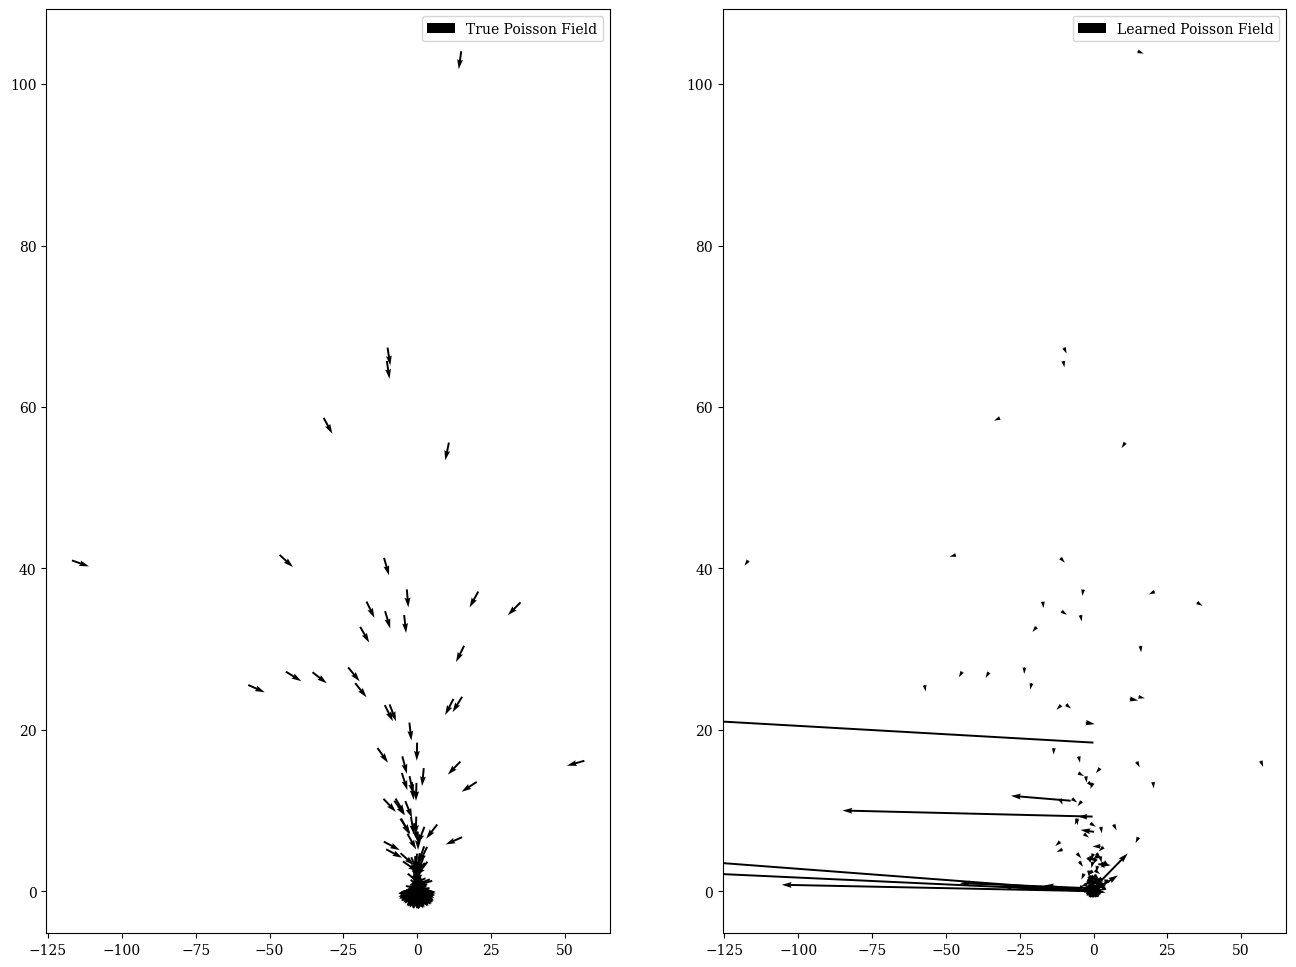

In [11]:
samples = prior_sampling((300,))
model_bd = trainer_load.bind_model()
y_pred = model_bd(samples)
fig, ax = plt.subplots(1,2, figsize=(16,12))
ax[0].quiver(x[0][:,0], x[0][:,1], x[1][:,0], x[1][:,1], label='True Poisson Field');
ax[0].legend();
ax[1].quiver(x[0][:,0], x[0][:,1], y_pred[:,0], y_pred[:,1], label='Learned Poisson Field');
ax[1].legend()
plt.show()


In [12]:
num_samples = 1000
range_vals = (-1.5, 1.5)

data, nfe = ode_sampler(num_samples, zmax=50, eps=1e-5, verbose=True, method='RK45')

xs = data[0]
zs = data[1]
sampled = xs[:, -1]
x = mkds.rho(rng, num_samples)
prior_samples = prior_sampling((num_samples,))


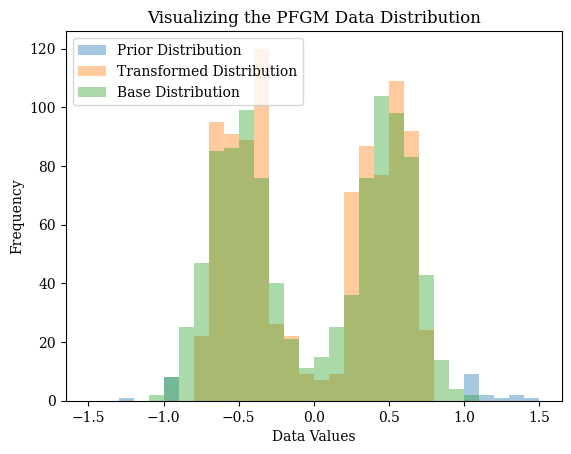

In [18]:
plt.hist(prior_samples[:,0], bins=30,  range=range_vals, alpha=0.4, label='Prior Distribution');
plt.hist(sampled, bins=30, range=range_vals, alpha=0.4, label='Transformed Distribution');
plt.hist(x[:,0], bins=30,  range=range_vals, alpha=0.4, label='Base Distribution');
plt.title('Visualizing the PFGM Data Distribution')
plt.ylabel('Frequency')
plt.xlabel('Data Values')
plt.legend()
plt.show()